In [15]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
customers = pd.read_csv('customers_dataset.csv')
print(customers.columns)
geolocation = pd.read_csv('geolocation_dataset.csv')
print(geolocation.columns)
orders = pd.read_csv('orders_dataset.csv')
print(orders.columns)
order_items = pd.read_csv('order_items_dataset.csv')
print(order_items.columns)
products = pd.read_csv('products_dataset.csv')
print(products.columns)
sellers = pd.read_csv('sellers_dataset.csv')
print(sellers.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')


# Tackling a Big Project with Limited Time: My Plan

### Here's what I’m thinking:
1. **First, I need to understand the problem.**
   The goal is clear: predict delivery dates more accurately to improve customer satisfaction. Right now, unexpected delays are frustrating customers and making them less likely to come back.

2. **Next, I’ll define the target.**
   To do that, I’ll calculate the actual delivery time for each order from the data.

3. **Feature Engineering comes next.**
   I’ll dig into the data to create meaningful features. Things like shipping distances, product sizes, seller and customer locations, and timestamps are probably going to be key. Geolocation data might also add a lot of value.

4. **EDA is important, but I’ll focus it.**
   Let’s be honest—exploratory data analysis (EDA) can take forever. Since time is tight, I’ll zoom in on the target-related variables and the features I created. This won’t be a full-blown EDA, but it’ll be enough to move forward.

5. **Then, I’ll build the model.**
    I plan to use regression models, beginning with the XGBoost Regressor, due to the complex relationships identified during the exploratory data analysis (EDA). Additionally, XGBoost offers excellent explainability. I will optimize the model's parameters and apply cross-validation for robustness. For evaluation, I will use RMSE, as it provides error values in the same unit as the target variable and is sensitive to outliers.

6. **Then, I’ll compare it to the baseline.**
   There’s already a black-box time estimation system in place. I’ll compare my model’s predictions to see if we’re really making things better.

7. **Finally, I will add the predictions to the purchase date to create the estimated delivery date, as requested.**

### That’s my approach—focused and prioritized to make the most of the time I’ve got.


In [99]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Calculate the actual delivery time in days
orders['actual_delivery_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

orders = orders.dropna(subset=['actual_delivery_days'])
percentile_99 = np.percentile(orders['actual_delivery_days'], 99)
orders = orders[orders['actual_delivery_days'] <= percentile_99]

orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])

orders['purchase_approve_days'] = (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.days
orders['approve_delivery_days'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.days

# Late deliveries are those delivered after the estimated date
orders['is_late'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(int)

# Temporal Features:
# Day of the week the order was placed.
orders['order_day_of_week'] = orders['order_purchase_timestamp'].dt.day_name()

# Extract the hour from the timestamp
orders['order_hour'] = orders['order_purchase_timestamp'].dt.hour

order_items = order_items.merge(
    orders[['order_id', 'customer_id', 'order_day_of_week', 'order_hour', 'is_late', 'purchase_approve_days', 'approve_delivery_days', 'actual_delivery_days']],
    on='order_id')


In [100]:
customers.drop_duplicates(
    subset=['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'],
    inplace=True
)

geolocation = geolocation.groupby(['geolocation_zip_code_prefix']).last().reset_index()


customers = customers.merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
customers = customers.rename(columns={
    'geolocation_lat': 'geolocation_lat_customer',
    'geolocation_lng': 'geolocation_lng_customer',
    'geolocation_city': 'geolocation_city_customer',
    'geolocation_state': 'geolocation_state_customer'
})

In [101]:
sellers = sellers.merge(geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
sellers = sellers.rename(columns={
    'geolocation_lat': 'geolocation_lat_seller',
    'geolocation_lng': 'geolocation_lng_seller',
    'geolocation_city': 'geolocation_city_seller',
    'geolocation_state': 'geolocation_state_seller'
})

In [102]:
# Geographic Features:
# Calculate distances between sellers and customers using geolocation data.

def calculate_distance(row, sellers_geo, customers_geo):
    seller_coords = sellers_geo.get(row['seller_id'])
    customer_coords = customers_geo.get(row['customer_id'])
    return geodesic(seller_coords, customer_coords).km if seller_coords and customer_coords else None

sellers.dropna(subset=['geolocation_lat_seller', 'geolocation_lng_seller'], inplace=True)
customers.dropna(subset=['geolocation_lat_customer', 'geolocation_lng_customer'], inplace=True)

sellers_geo = sellers.set_index('seller_id')[['geolocation_lat_seller', 'geolocation_lng_seller']].apply(tuple, axis=1).to_dict()
customers_geo = customers.set_index('customer_id')[['geolocation_lat_customer', 'geolocation_lng_customer']].apply(tuple, axis=1).to_dict()
order_items['distance_km'] = order_items.apply(lambda row: calculate_distance(row, sellers_geo, customers_geo), axis=1)

In [103]:
# Order Features:
# Number of items in the order.
order_items['item_count'] = order_items.groupby('order_id')['product_id'].transform('count')
# Total price of the order.
order_items['total_price'] = order_items.groupby('order_id')['price'].transform('sum')
# Total price of the freight of the order.
order_items['total_freight_price'] = order_items.groupby('order_id')['freight_value'].transform('sum')
# Weight and dimensions of items (from the product dataset).
order_items = order_items.merge(products[['product_id', 'product_category_name', 'product_weight_g', 'product_length_cm',
                                          'product_height_cm', 'product_width_cm']],
                                on='product_id', how='left')
order_items['product_volume_cm3'] = (order_items['product_length_cm'] *
                                     order_items['product_height_cm'] *
                                     order_items['product_width_cm'])
# Total weight of the order.
order_items['total_weight'] = order_items.groupby('order_id')['product_weight_g'].transform('sum')

In [104]:
# Seller Performance:
# Average delivery time for each seller.
seller_performance = order_items.groupby('seller_id')['actual_delivery_days'].mean().reset_index(name='avg_delivery_time')

# Count of late deliveries per seller.
late_deliveries = order_items.groupby('seller_id')['is_late'].sum().reset_index(name='late_deliveries')
# seller_num_products = order_items.groupby('seller_id')['product_id'].nunique().reset_index(name='seller_num_products')

order_items = order_items.merge(late_deliveries, on='seller_id')
order_items = order_items.merge(seller_performance, on='seller_id')

In [105]:
for clean in ['purchase_approve_days', 'approve_delivery_days', 'distance_km', 'total_price', 'total_freight_price', 'product_weight_g']:
    print(clean)
    print(order_items.shape)
    order_items = order_items.dropna(subset=[clean])
    print(order_items.shape)
    percentile_99 = np.percentile(order_items[clean], 99)
    order_items = order_items[order_items[clean] <= percentile_99]
#
print(order_items.shape)
order_items = order_items.dropna(subset=['approve_delivery_days'])
print(order_items.shape)
percentile_01 = np.percentile(order_items['approve_delivery_days'], 1)
order_items = order_items[order_items['approve_delivery_days'] > percentile_01]

purchase_approve_days
(109230, 27)
(109215, 27)
approve_delivery_days
(108364, 27)
(108364, 27)
distance_km
(107382, 27)
(103273, 27)
total_price
(102240, 27)
(102240, 27)
total_freight_price
(101232, 27)
(101232, 27)
product_weight_g
(100223, 27)
(100208, 27)
(99224, 27)
(99224, 27)


In [106]:
numerical_features = [
    'price', 'freight_value', 'purchase_approve_days',
    'approve_delivery_days',
    'distance_km', 'item_count', 'total_price', 'total_freight_price',
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'product_volume_cm3', 'total_weight',
    'late_deliveries', 'avg_delivery_time'
]

categorical_features = ['order_day_of_week', 'order_hour', 'is_late', 'product_category_name']

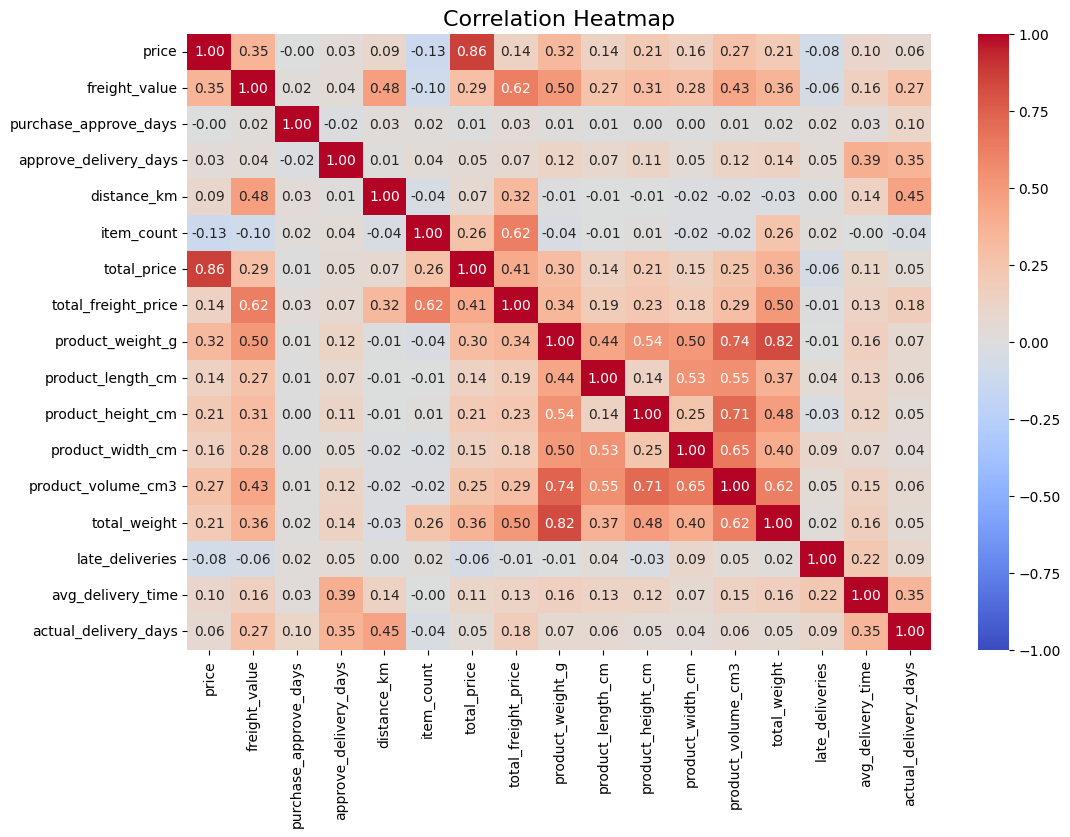

In [68]:
import numpy as np

correlation_matrix = order_items[numerical_features + ['actual_delivery_days']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


In [ ]:
# It seems the target variable shows some correlation with the seller's average delivery time, the distance in kilometers, the number of days from approval to delivery, and the freight value.
# Together, these features suggest a narrative about sellers who ship to distant locations and potentially specific sellers who consistently take longer to deliver.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


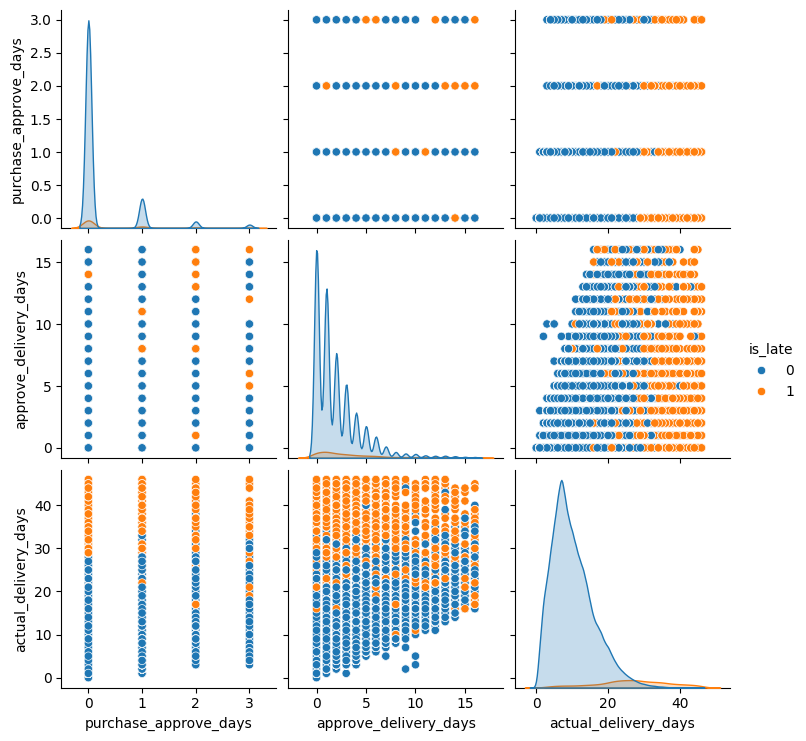

In [70]:
sns.pairplot(order_items, vars=['purchase_approve_days', 'approve_delivery_days'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


In [ ]:
# Here, we observe that higher approval-to-delivery days are associated with longer actual delivery times, while the time elapsed from purchase to approval doesn't seem to have a significant impact.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


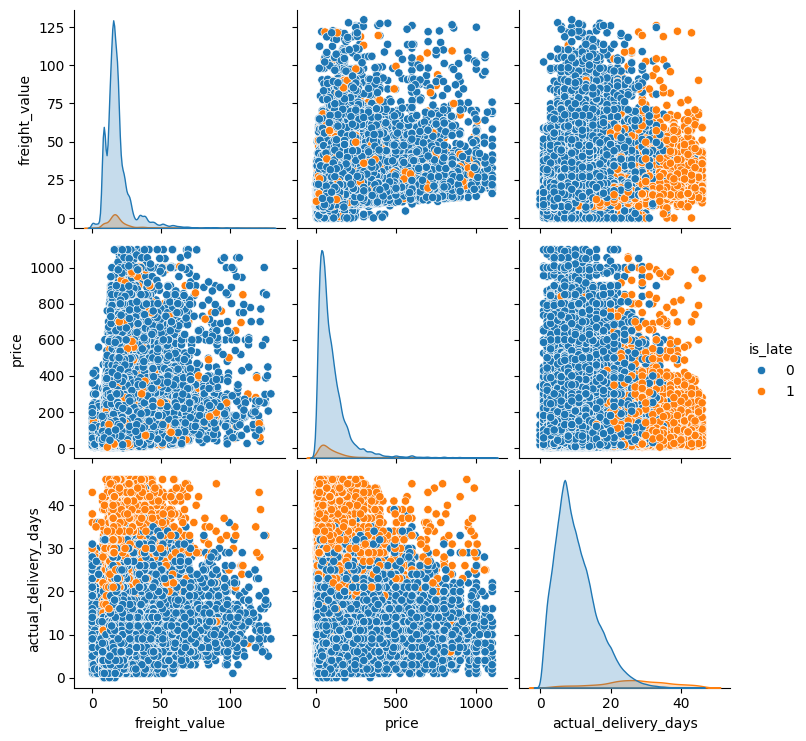

In [71]:
sns.pairplot(order_items, vars=['freight_value', 'price'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


In [ ]:
#Here, we observe that higher prices are associated with fewer late deliveries and shorter delivery times. A similar trend is evident for higher freight values and that cheaper freight values tend to not to be late.
#

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

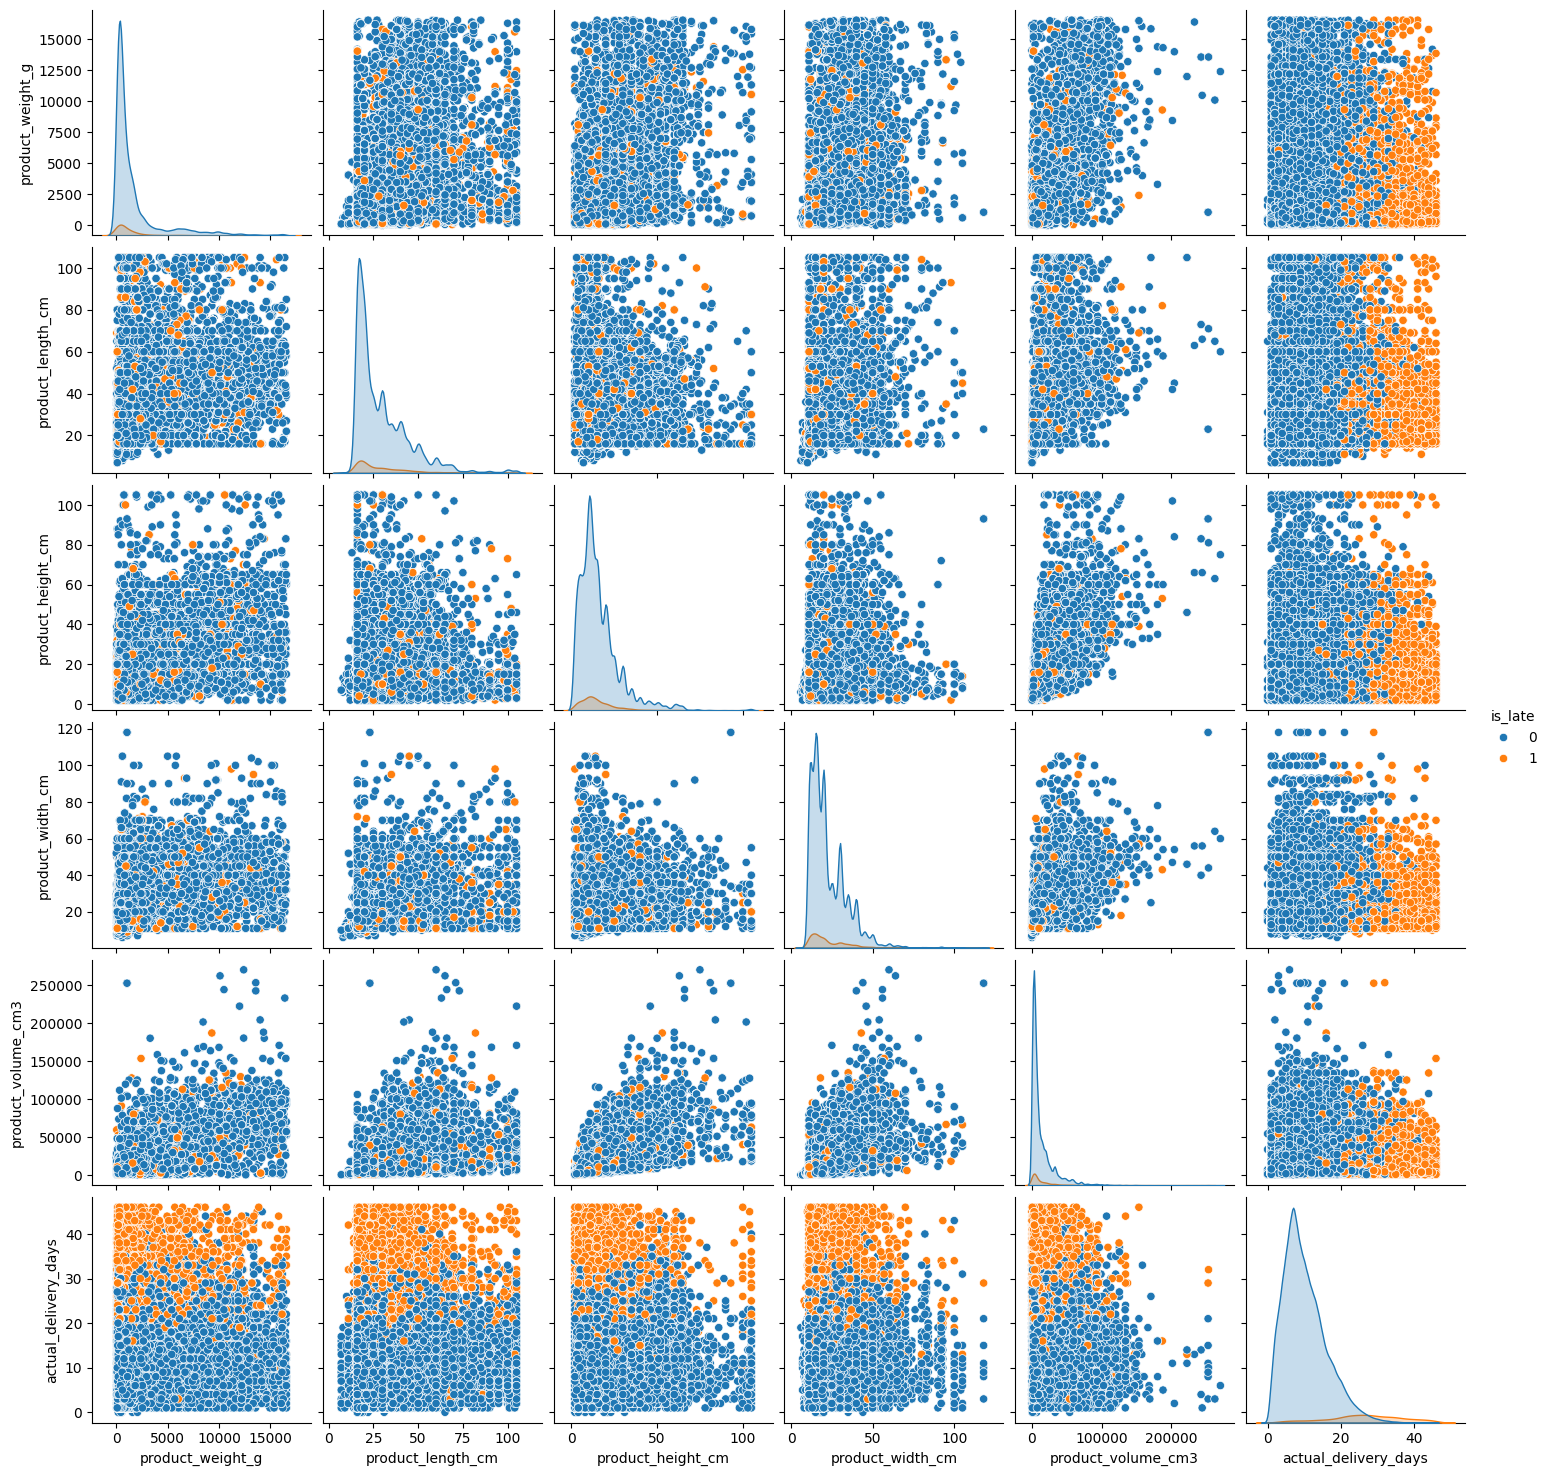

In [72]:
sns.pairplot(order_items, vars=['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_volume_cm3'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()

In [ ]:
#Here, we see that the size and shape of the products do impact delivery times.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

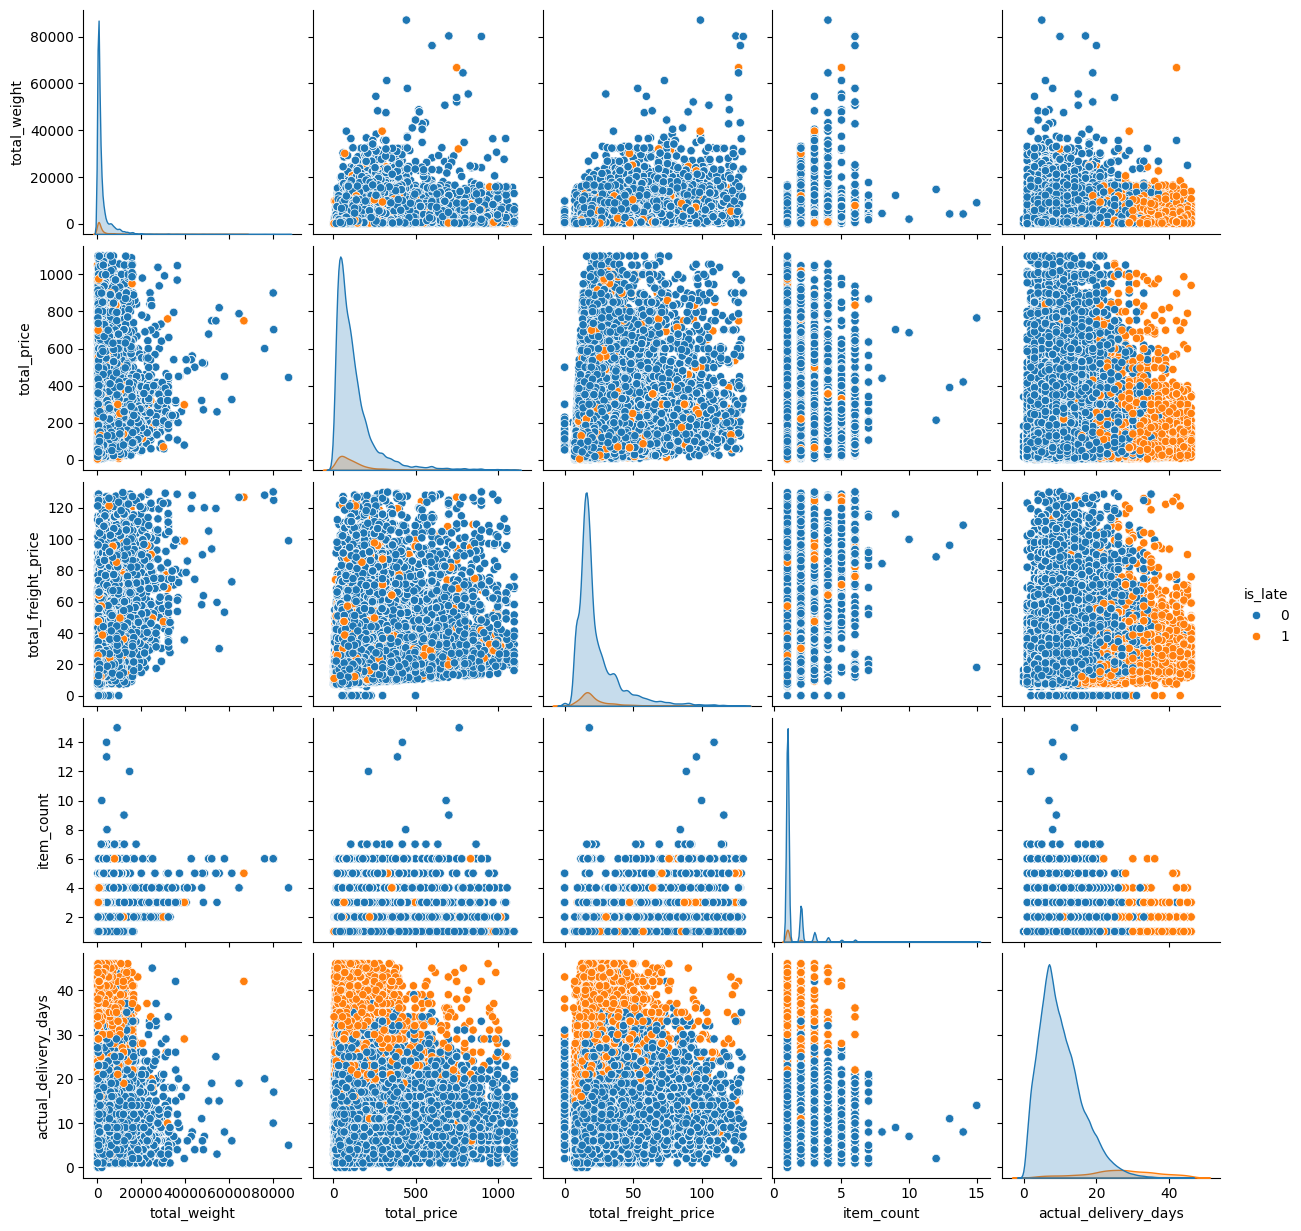

In [73]:
sns.pairplot(order_items, vars=['total_weight', 'total_price', 'total_freight_price', 'item_count'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


In [ ]:
#Here, we see that the total size and shape of the products in an order do not impact delivery times.
# But, the higher the total price and freight price are, the shorter the delivery days, and they tend to late less.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

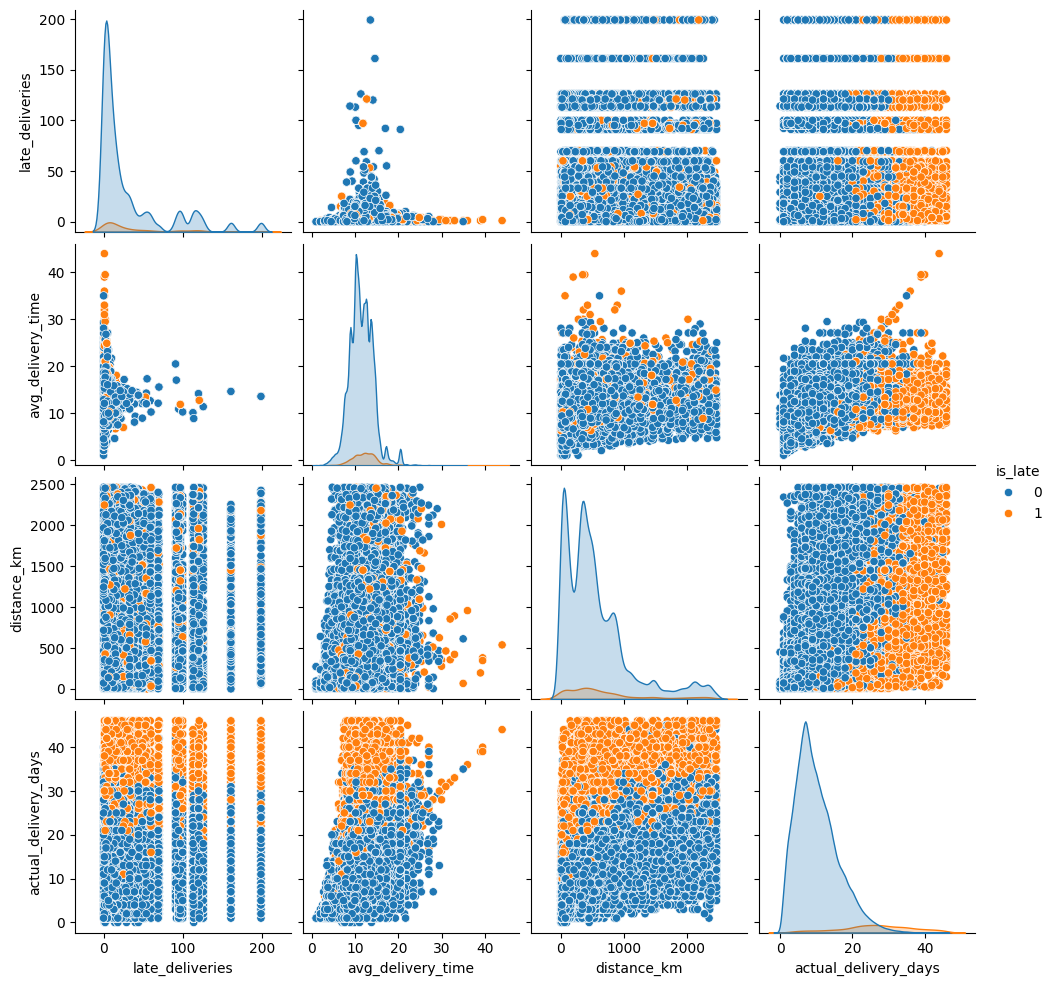

In [74]:
sns.pairplot(order_items, vars=['late_deliveries', 'avg_delivery_time', 'distance_km'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


In [75]:
# Here, we observe that orders sent to more distant locations tend to take longer to arrive. Additionally, there is an interesting correlation between a seller's average delivery time and the likelihood of late deliveries.

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


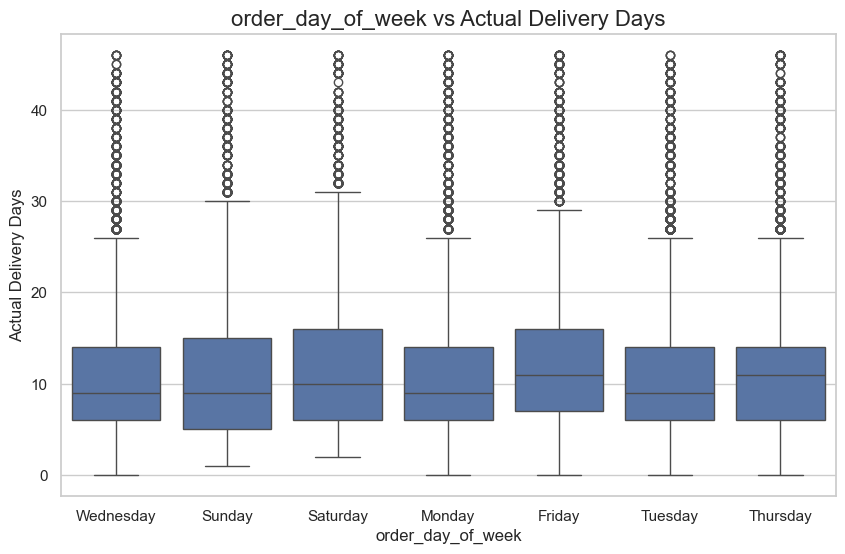

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


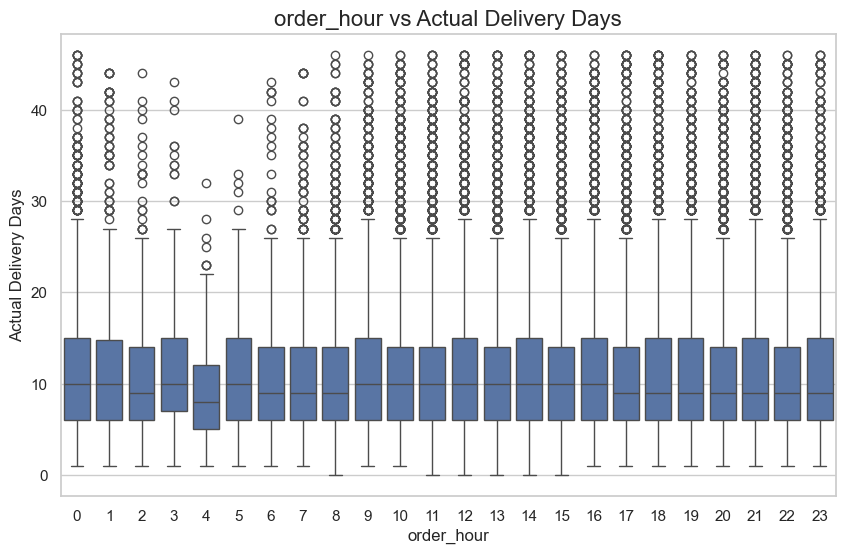

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


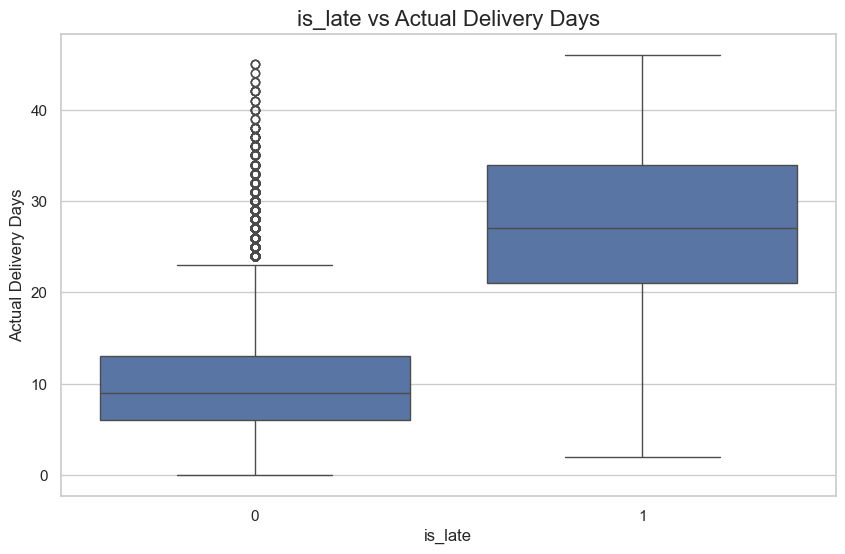

/opt/homebrew/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


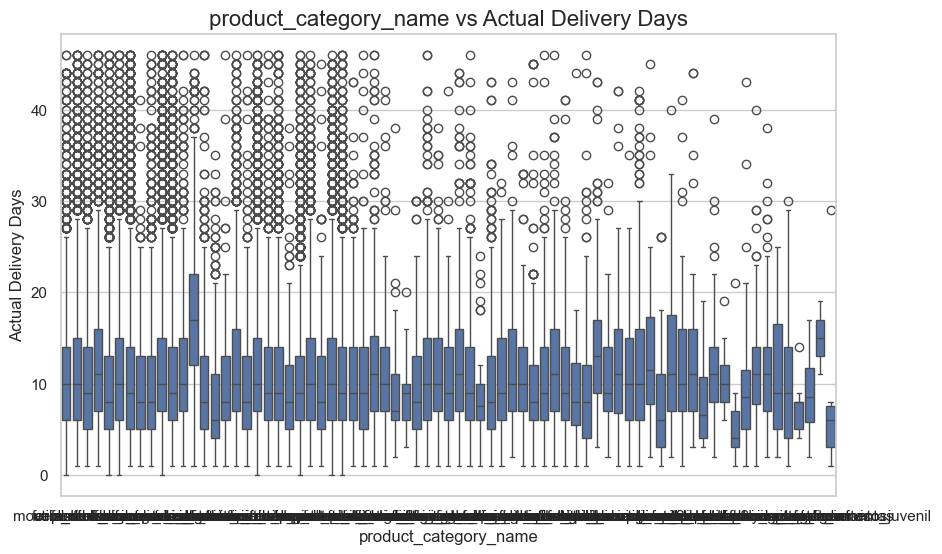

In [107]:
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='actual_delivery_days', data=order_items)
    plt.title(f'{feature} vs Actual Delivery Days', fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Actual Delivery Days', fontsize=12)
    plt.show()


In [ ]:
# there are some product_category_name that has shorter time of delivery (if I would have time, I will make the x axis more readable)

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


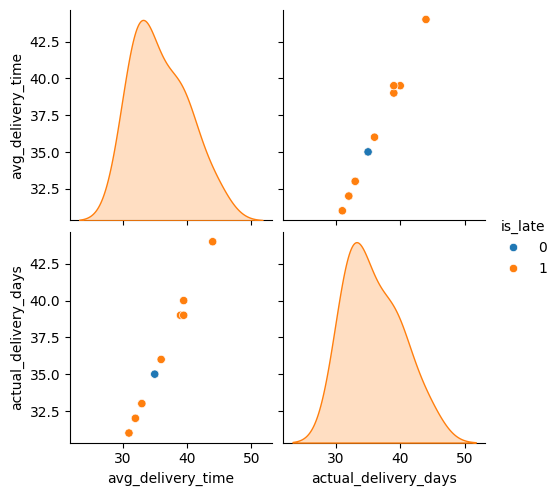

In [83]:
sns.pairplot(order_items[order_items['avg_delivery_time'] > 30], vars=['avg_delivery_time'] + ['actual_delivery_days'], diag_kind='kde', kind='scatter', hue='is_late')
plt.show()


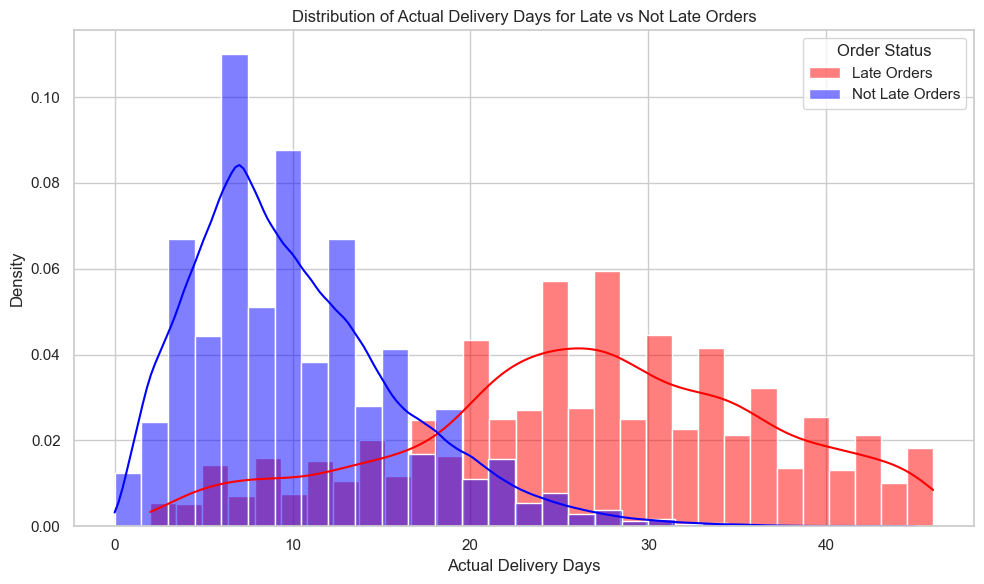

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

late_orders = order_items[order_items['is_late'] == 1]
not_late_orders = order_items[order_items['is_late'] == 0]

plt.figure(figsize=(10, 6))
sns.histplot(late_orders['actual_delivery_days'], bins=30, kde=True, color='red', label='Late Orders', stat="density")
sns.histplot(not_late_orders['actual_delivery_days'], bins=30, kde=True, color='blue', label='Not Late Orders', stat="density")

plt.title('Distribution of Actual Delivery Days for Late vs Not Late Orders')
plt.xlabel('Actual Delivery Days')
plt.ylabel('Density')
plt.legend(title='Order Status')
plt.tight_layout()
plt.show()


In [ ]:
#It appears that around 20 days is the cutoff, with orders that are not late typically delivered within 20 days, while late orders tend to be delivered after 20 days.

In [ ]:
# If I had more time, I would explore the following ideas:
# Analyze actual_delivery_days by city and country to identify patterns. This could help pinpoint specific post offices or regions that might be responsible for delays.
# Investigate actual_delivery_days by product type to see if certain products have longer delivery times compared to others.

In [119]:
import optuna
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

numerical_features = [
    'price', 'freight_value', 'purchase_approve_days',
    'approve_delivery_days',
    'distance_km', 'item_count', 'total_price', 'total_freight_price',
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'product_volume_cm3', 'total_weight',
    'late_deliveries', 'avg_delivery_time'
]

categorical_features = ['order_day_of_week', 'order_hour', 'is_late', 'product_category_name']
df = order_items.copy()

df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

X = df_encoded.drop(columns=['order_id', 'product_id', 'seller_id', 'shipping_limit_date', 'customer_id', 'actual_delivery_days'])
y = df_encoded['actual_delivery_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Trial will choose values between 3 and 10
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # Learning rate between 0.01 and 0.2
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Number of trees
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Subsampling ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # Feature fraction
        'gamma': trial.suggest_float('gamma', 0, 5),  # Regularization term
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Minimum sum of instance weight
    }

    model = xgb.XGBRegressor(**param)

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE with best parameters: {rmse}")

[I 2024-12-05 00:46:55,928] A new study created in memory with name: no-name-06cb3541-578d-4004-9609-83c132a3997b
[I 2024-12-05 00:47:03,196] Trial 0 finished with value: 4.272579135037697 and parameters: {'max_depth': 5, 'learning_rate': 0.16158530499069987, 'n_estimators': 204, 'subsample': 0.787035686522678, 'colsample_bytree': 0.925777046359237, 'gamma': 4.247621931282529, 'min_child_weight': 4}. Best is trial 0 with value: 4.272579135037697.
[I 2024-12-05 00:47:19,485] Trial 1 finished with value: 4.251128049282592 and parameters: {'max_depth': 9, 'learning_rate': 0.02092127449791175, 'n_estimators': 243, 'subsample': 0.9189596226423946, 'colsample_bytree': 0.7002748629092332, 'gamma': 2.7655409117138676, 'min_child_weight': 9}. Best is trial 1 with value: 4.251128049282592.
[I 2024-12-05 00:47:28,223] Trial 2 finished with value: 4.3131560426320625 and parameters: {'max_depth': 3, 'learning_rate': 0.19538065939761048, 'n_estimators': 357, 'subsample': 0.9831977177894214, 'colsamp

Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.02092127449791175, 'n_estimators': 243, 'subsample': 0.9189596226423946, 'colsample_bytree': 0.7002748629092332, 'gamma': 2.7655409117138676, 'min_child_weight': 9}
Final RMSE with best parameters: 4.223329344758299


In [121]:
# just to show the predictions on the data:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
df = df.merge(
    orders[['order_id','order_purchase_timestamp']],
    on='order_id')

df['predicted_delivery_date'] = pd.to_datetime(df['order_purchase_timestamp']) + pd.to_timedelta(best_model.predict(X), unit='D')

df[['order_purchase_timestamp', 'predicted_delivery_date']].head()


order_purchase_timestamp       predicted_delivery_date
0      2017-09-13 08:59:02 2017-09-25 19:37:16.961547855
1      2018-01-14 14:33:31 2018-01-22 18:34:06.705566405
2      2018-08-08 10:00:35 2018-08-17 03:06:38.922119144
3      2017-02-04 13:57:51 2017-02-25 10:17:00.005126954
4      2017-05-15 21:42:34 2017-05-23 06:14:03.263916017

In [126]:
import numpy as np
from sklearn.metrics import mean_squared_error

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

merged_df = pd.merge(orders[['order_id', 'order_estimated_delivery_date']], df[['order_id', 'predicted_delivery_date']], on='order_id', how='left')
merged_df['day_diff'] = (merged_df['predicted_delivery_date'] - merged_df['order_estimated_delivery_date']).dt.days
merged_df = merged_df.dropna()
rmse = np.sqrt(mean_squared_error(merged_df['day_diff'], np.zeros_like(merged_df['day_diff'])))
print(f"RMSE between predicted and actual delivery date differences: {rmse}")


RMSE between predicted and actual delivery date differences: 15.066626444496174


In [127]:
# Our model achieved an RMSE of 4.22, compared to the baseline RMSE of 15.
# A lower RMSE value indicates a better model, as it means the model's predictions are closer to the actual values.

### Questions for the Product Manager:

- What is shipping_limit_date? can we use this to make more features like time untill this date?
- Do we have any benchmarks for seller performance in terms of delivery times? Are there actions we’re taking to help sellers with longer delivery times improve?

- How do we handle logistics for distant locations? Are there specific factors (like carrier limitations or warehouse locations) that contribute to longer delivery times in those areas?

- Can we set some targets for the "approval-to-delivery" duration? Is there an ideal range for this metric?

- Are there any strategies to optimize freight costs? Do we have any goals around the relationship between product price, freight value, and delivery performance?

- Are there any pricing strategies in place to encourage faster delivery times?

- Are we prioritizing certain sellers based on their delivery times or service levels? Do we have KPIs in place to track and support sellers that need help?

- Can we track the reasons for orders that are consistently late (over 20 days)?


### Recommendations:

- We could focus on identifying sellers who consistently have higher average delivery times. Offering them additional support or setting stricter SLAs (Service Level Agreements) might help improve their performance.

- Consider optimizing logistics for sellers who frequently ship to distant locations. This could involve partnering with more efficient shipping carriers or offering discounts for expedited deliveries to high-priority regions.

- Higher prices and freight values seem to correlate with fewer late deliveries and shorter delivery times. We could consider offering promotions or incentives for sellers who use higher-value freight options, thus improving delivery performance.

- It might be useful to identify specific types of products (especially large or fragile items) that consistently lead to delays.

- Sellers with long delivery times could benefit from performance improvement initiatives or tailored support.

- Investigating the causes behind late orders (e.g., delays at the warehouse, customs issues, or carrier problems) could provide valuable insights for improving delivery times.


### What can we expect in production?

1. **Model Deployment**:
   After training, the XGBoost model will be deployed to make predictions on new data. This means it’ll predict delivery times or other target variables for incoming orders.

2. **Data Handling**:
   The data pipeline will handle incoming data from multiple sources (like sellers or logistics systems). We’ll need to clean any missing or inconsistent data and make sure features are processed correctly for the model.

3. **Model Monitoring**:
   Once the model is live, we’ll keep an eye on its performance. We’ll track its accuracy, check for any changes in the input data (data drift), and make sure it stays reliable. If it starts underperforming, we may need to retrain it or tweak it.

4. **Business Impact**:
   The model will help optimize processes by identifying high-risk orders that may be delayed or flagging sellers with slower delivery times. This lets the team take action before things go wrong.

5. **User Interaction**:
   Depending on how the system is set up, business users (like sales or logistics teams) will interact with the model’s predictions. For example, if the model predicts delays, they can adjust shipping or inform customers ahead of time.

6. **Scalability**:
   As we get more data (new sellers, regions, etc.), the system will need to handle it. This might mean adding new features or adjusting the model to keep things running smoothly.

7. **Feedback Loop**:
   We'll compare the model's predictions to actual outcomes (e.g., was the delivery late or on time?). This feedback will help us improve the model over time.

8. **Performance Optimization**:
   Depending on the setup (cloud, on-premise), we might need to optimize the system to make predictions quickly, especially if we’re doing real-time predictions for a lot of orders.
